<a href="https://colab.research.google.com/github/ma23m017/Time_Series/blob/main/SES(Simple_Exponential_Smoothing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this file we are going to see the code of EWMA(Exponentially Weighted Moving Average). We will use the "Airline Passengers" dataset.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("/content/airline_passengers.csv", index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


We will check whether any row contains null value or not

In [3]:
df.isna().sum()

Passengers    0
dtype: int64

Above we can see that there is some value given for each row, so next we are going to plot the data

<Axes: xlabel='Month'>

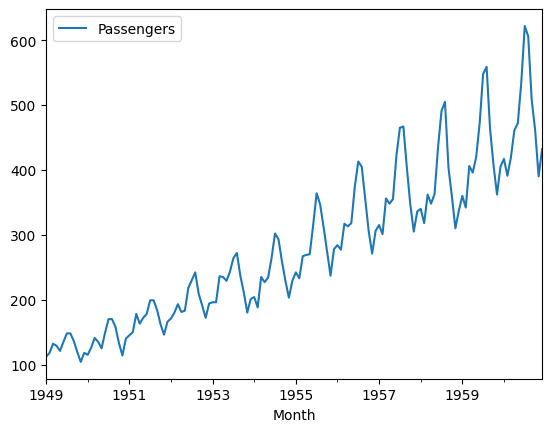

In [4]:
df.plot()

From the above graph we can say that this looks nothing like a typical stock price time series. There seems to be very little randomness in this dataset. In fact, that would meen that this wold be a hreat candidate for statistical and machine learning techinques. Machine learning is all about recognizing and modelling patterns, annd clearly there is a pettern here. On the other hand, stock price might be characterised by their lack of patterns.

We can see that with this dataset, there seems to be a trend component and the cyclical component. Trend means signal is generally going upwards, the cyclical component means that there is some peroidicity where the same pattern repeats itself. We can see that this cyclical pattern actually amplifies over time, so it's not a constatnt cyclical pattern. It is also difficult to tell whether the trend is increasing linearly or if that is also increasing over time and perhaps exponentially. In this time series we don't have enough data to see that.

In [5]:
alpha = 0.2 # choosing the value of alpha

In [6]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [7]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

<Axes: xlabel='Month'>

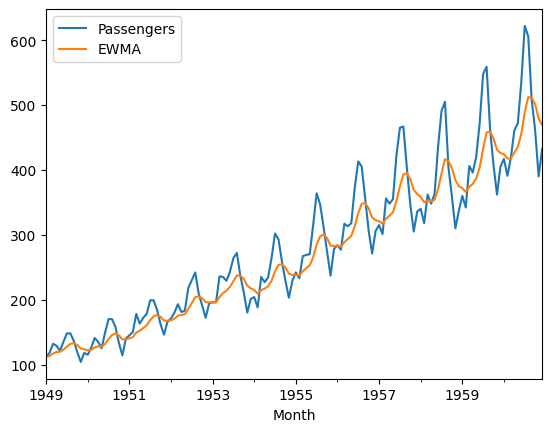

In [8]:
df.plot()

Next we try to create ewma function manually and will verify whether pandas is doing the calculation right or not.

In [9]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha*x + (1-alpha)*manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

In [10]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


<Axes: xlabel='Month'>

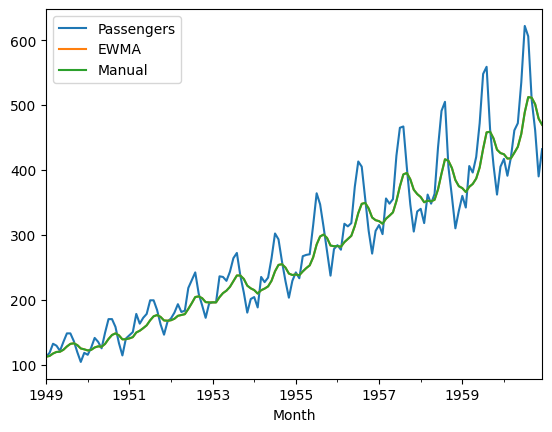

In [11]:
df.plot()

In [12]:
df.drop('Manual', axis = 1, inplace = True)

Now we are going to import simple exponential smoothing class.

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [14]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [16]:
df.index.freq = 'MS'  # MS means months. MS is used as frequency

Next we are going to make another instance of the simple smoothing class with the newly updated data

In [17]:
ses = SimpleExpSmoothing(df['Passengers'], initialization_method='legacy-heuristic') # now we will get no warnings

The next step is to call the fit function on our model, also we are going to set fixed alpha.

In [18]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [19]:
res

The next step is to call the predict function on result's object, since we want prediction for our entire dataset. We are going to pass the start date equal to the first row index of our dataframe and end date equal to the last row index of our dataframe

In [20]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

Next we are going to call the same function again, but this time we will assign it to the new column of our dataframe.

In [21]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

Since we called the predict function for the "in sample"(data that we already have) dates, so we want check whether this predict function actually returns the same thing as the fitted value attributes or not.

In [22]:
np.allclose(df['SES'], res.fittedvalues)

True

In [23]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


<Axes: xlabel='Month'>

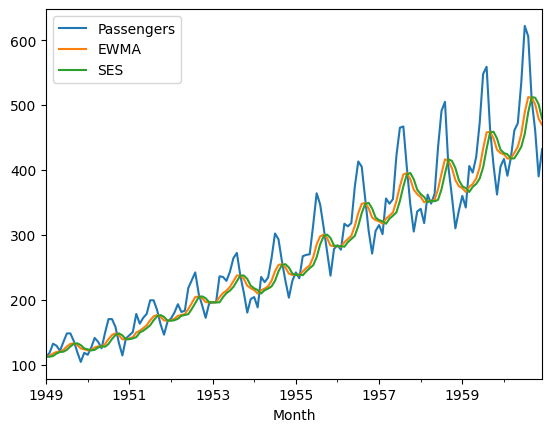

In [24]:
df.plot()

Recall that the forecasting model is defined as slightly differently from the traditional EWMA, forecasting time index is moved up by one step. EWMA is represented by the level, but the prediction y^ is actually assigns the level at the previous time step. In other words SES should be lagging behind by one time step.

Next we will treat this problem as a machine learning problem.

In [25]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [26]:
ses = SimpleExpSmoothing(train['Passengers'], initialization_method='legacy-heuristic') # function automatically finds the best alpha
res = ses.fit()

In [31]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

<Axes: xlabel='Month'>

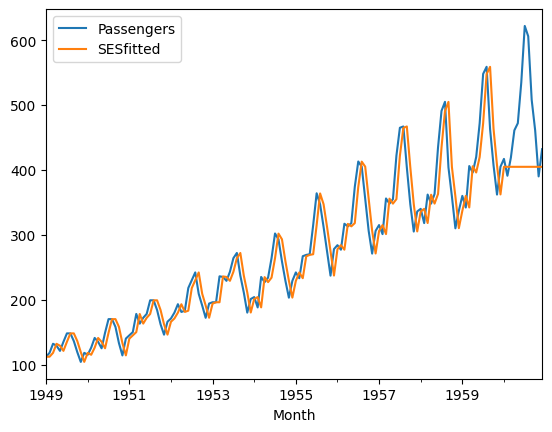

In [33]:
df.loc[train_idx,'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot()

In [34]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}